# Pipeline to remove Odontomachus ruginodis (Orug) contamination from Camponotus planatus (Cpla) transcriptome
This takes single gene phylogenies as input, along with the transcriptomes and other stuff

## Table of Contents

1. For ~3500 candidate genes that have >90% similarity to a gene in Orug, find their peptide sequences (MAGOT), find their best hit in 11 other Apoidea (BLASTP), align (MAFFT), and build ML phylogenies (RAxML)
2. Read in trees and analyse
3. Construct dataframe with sequence and phylogenetic features
4. Plots showing that these features indicate contamination
5. Identify and remove contaminants from the transcriptome

In [1]:
import itertools
import os

In [2]:
from Bio import SeqIO
from ete3 import Tree

In [3]:
import numpy as np
import pandas as pd

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## 1. For ~3500 candidate genes that have >90% similarity to a gene in Orug, find their peptide sequences (MAGOT), find their best hit in 11 other Apoidea (BLASTP), align (MAFFT), and build ML phylogenies (RAxML)

The best BLAST result for each of these resultant Cpla candidate genes from a range of Hymenoptera was determined.

In [5]:
#Feed in list of candidate Cpla sequences from which to identify contaminated genes. 
#This list contains 3510 genes that have >90% identity to their best blastp hit in Orug
s_Cpla_candidates = pd.read_table('Cpla_candidates.txt', header = None)
print(len(s_Cpla_candidates))
s_Cpla_candidates.head()

3510


,0
0,Cpla|SGF52724
1,Cpla|SGF48080
2,Cpla|SGF52907
3,Cpla|SGF52908
4,Cpla|SGF55108


In [6]:
# create dictionary of blast results
blast_cols  = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
sp_list = ['Aech', 'Amel', 'Bimp', 'Cflo', 'Dqua', 'Hsal', 'Lnig', 'Mrot', 'Obir', 'Orug', 'Sinv']
fp_list = ["contam_Cpla_vs_{}.bx".format(x) for x in sp_list ]
           
sp_blast = { sp:pd.read_csv(os.path.join("contamination_assessment",fp), 
                            header=None, 
                            names=blast_cols,
                            sep='\t',
                           ) for sp,fp in zip(sp_list, fp_list)}

In [7]:
sp_blast['Amel'].head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,Cpla|SGF46838,Amel|LOC726178,89.89,89,7,1,15,103,110,196,6.000000e-49,164.0
1,Cpla|SGF46839,Amel|STXBP5,90.71,140,10,1,2,138,1232,1371,4.000000e-83,266.0
2,Cpla|SGF46841,Amel|LOC552637,95.42,306,14,0,1,306,1,306,0.000000e+00,617.0
3,Cpla|SGF46844,Amel|LOC725680,88.78,740,82,1,2,740,4,743,0.000000e+00,1358.0
4,Cpla|SGF46848,Amel|LOC409711,82.40,125,9,3,1,116,1006,1126,1.000000e-43,153.0


In [8]:
# get all genes with an evalue match < 0.01
df_concat1 = pd.concat([sp_blast[sp][sp_blast[sp]['evalue'] < 0.01] for sp in sp_list], axis=0)

In [9]:
df_cpla_hits = df_concat1.pivot_table(values='sseqid', 
                                       index='qseqid', 
                                       aggfunc=lambda x: list(x)
                                      )

/Users/vchandra/anaconda/envs/ilp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


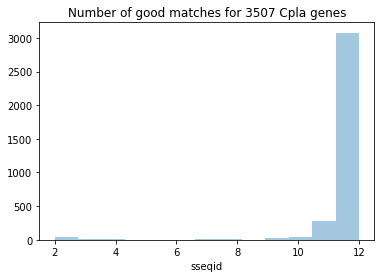

In [10]:
sns.distplot(df_cpla_hits.sseqid.apply(lambda s: len(s)+1), kde=False, bins=13)
plt.title("Number of good matches for {} Cpla genes".format(len(df_cpla_hits)))
plt.show()

The above figure shows that most of the candidate contaminant genes have a good match from all of the reference genomes.

In [12]:
#save lists of Cpla orthologue groups; one group per file
for ogene in df_cpla_hits.index:
    handle = open('Cpla_gene_lists/{}.out'.format(ogene), 'w')
    handle.write('\n'.join(df_cpla_hits.loc[ogene][0]))

## Used mafft and raxml on the server to construct phylogenies for each of these orthologue groups (scripts attached below)

### MAGOT Script
This script takes each species' gene name, searches the corresponding peptidome and returns the peptide sequence for each gene. Install from https://github.com/biorover/MAGOT

```
#!/usr/bin/bash

for SPECIES in Aech Bimp Amel Cflo Cpla Dqua Hsal Lnig Obir Orug Mrot Sinv; 
do 
    for i in $(cat ${SPECIES}_candidate_seqs.txt); 
    do 

        MAGOT get_seq_from_fasta '${SPECIES}.pep' $i True >> ${i}_seqs.fasta 

    done
done
```

### MAFFT Script

As input, this takes lists of sequences (one sequence from each of roughly 12 species' peptidomes), and performs a multiple sequence alignment. 

```
#!/usr/bin/bash

for i in $(ls 'Cpla_candidates/Cpla_sequences/'); do

   mafft --localpair --thread 30 --maxiterate 1000 Cpla_candidates/Cpla_sequences/$i > $i.aligned

done
```

### RAxML Script

This takes multiple sequence alignments as input and generates maximum likelihood phylogenies for each alignment. 

```
#!/usr/bin/bash

for i in $(ls 'Cpla_candidates/alignments/'); do

    raxml -s Cpla_candidates/alignments/$i -m PROTGAMMAJTT -p 6666 -T 30 -n $i.out 

done
```

## 2. Read in trees and analyse

In [13]:
#list all phylogenies for Orug candidate genes in treelist
treelist = []
for file in os.listdir('contamination_assessment/Cpla_trees/'):
    if 'bestTree' in file:
        treelist.append('contamination_assessment/Cpla_trees/' + file)

print(len(treelist))

3463


In [14]:
#print examples of these phylogenies

#note that genes beginning with 'KM' are from Lasius niger. All other species are 
#named following the four letter nomenclature: 
#first letter from the first letter of the genus, and the next three letters from the start of the species name

for i in range(0, 2):
    x = Tree(treelist[i])
    print(x)


      /-Cflo|XP_011267623.1
   /-|
  |  |   /-Cbir|LOC105287556
  |   \-|
  |      \-Dqua|LOC106750675
  |
  |         /-Sinv|XP_011174656.1
  |      /-|
  |     |  |   /-KMQ82389.1
  |     |   \-|
  |     |     |   /-Mrot|XP_003705009.1
--|     |      \-|
  |   /-|        |   /-Bimp|XP_003485579.1
  |  |  |         \-|
  |  |  |            \-Amel|mamo
  |  |  |
  |--|  |   /-Orug|SGF61798
  |  |   \-|
  |  |      \-Hsal|LOC105180637
  |  |
  |   \-Aech|XP_011060921.1
  |
   \-Cpla|SGF48905

      /-Cbir|LOC105281692
     |
     |            /-Dqua|LOC106747065
     |         /-|
   /-|      /-|   \-Hsal|LOC105192301
  |  |     |  |
  |  |   /-|   \-Orug|SGF80530
  |  |  |  |
  |  |  |  |   /-Bimp|XP_003493701.1
  |   \-|   \-|
  |     |      \-Amel|LOC100576908
--|     |
  |     |   /-Sinv|XP_011159071.1
  |      \-|
  |         \-Aech|XP_011059894.1
  |
  |--Cflo|XP_011264024.1
  |
   \-Cpla|SGF62474


In [15]:
# for each tree in the list, ask whether Cpla is sister to Orug. 
# store names of possible contaminant sequences
# store distances between Orug and Cpla in separate files; one for good trees and one for possible contaminants
# plot distributions of these distances

contaminants = {}
good_genes = {}
s_clade = {}
bee_tree_errors = []
no_bees = []
weird_bees = []
s_clade_errors = []
bee_seq_errors = []
scl1 = 0
nobiroi = []
fail = []
sis_clade_fail = []


for tree in treelist:
    Cpla = ''
    Orug = ''
    Cflo = ''
    Lnig = ''
    Hsal = ''
    Dqua = ''
    Mrot = ''
    Amel = ''
    Bimp = ''
    x = ''
    sis_clade = ''
    bee_ancestor = []
    bad = False

    intree = Tree(tree)
    for leaf in intree: 
        if 'Mrot' in leaf.name:
            Mrot = leaf.name
        elif 'Amel' in leaf.name:
            Amel = leaf.name
        elif 'Bimp' in leaf.name:
            Bimp = leaf.name
        elif 'Cbir' in leaf.name:
            Obir = leaf.name
    
    #find bees
    nbees = []
    for i in [Mrot, Amel, Bimp]:
        if i != '':
            nbees.append(i)
    
    #find ancestor of all bees
    try:
        if len(nbees) > 1:
            bee_ancestor = intree.get_common_ancestor(nbees)
        elif len(nbees) == 1:
            bee_ancestor = [nbees[0]]
        else:
            no_bees.append(tree)
    except:
        bee_seq_errors.append(tree)
        continue
    
    #reroot tree on ancestral bee (allow bee clade to contain up to one non-bee and if not, try rooting on any one bee)
    if len(bee_ancestor) <= 4 and len(bee_ancestor) > 1:
        intree.set_outgroup(bee_ancestor)
    elif len(bee_ancestor) > 4 or len(bee_ancestor) == 1:
        intree.set_outgroup(nbees[0])
        weird_bees.append(tree)
    elif len(bee_ancestor) == 0:
        try:
            intree.set_outgroup(Obir)
        except:
            nobiroi.append(tree)
            bad = True
    
    if not bad:
        for leaf in intree:
            if 'Cpla' in leaf.name:
                Cpla = leaf.name
            elif 'Orug' in leaf.name:
                Orug = leaf.name
            elif 'Hsal' in leaf.name:
                Hsal = leaf.name
            elif 'KM' in leaf.name:
                Lnig = leaf.name
            elif 'Dqua' in leaf.name:
                Dqua = leaf.name
            elif 'Cflo' in leaf.name:
                Cflo = leaf.name
                
                

        if len(Orug) > 0: 
            x = str(tree)
            x = x.split('.')
            x = x[1]
            cont_check = intree.get_common_ancestor(Cpla, Orug)
            if len(cont_check) == 2:
                contaminants[x] = intree.get_distance(Cpla, Orug)
            elif len(cont_check) > 2:
                good_genes[x] = intree.get_distance(Cpla, Orug)
            sis_clade = cont_check.get_sisters()
            
            if sis_clade != '':
                if Lnig != '' and Cflo != '' and Dqua != '' and Hsal != '':
                    Hmrca = intree.get_common_ancestor(cont_check, Hsal)
                    Dmrca = intree.get_common_ancestor(cont_check, Dqua)
                    Cmrca = intree.get_common_ancestor(cont_check, Cflo)
                    Lmrca = intree.get_common_ancestor(cont_check, Lnig)
                    Pav = min(len(Hmrca), len(Dmrca))
                    Fav = min(len(Cmrca), len(Lmrca))
                
                    if len(sis_clade) == 1:
                        if Pav > Fav:
                            s_clade[x] = 'F'
                        elif Pav < Fav:
                            s_clade[x] = 'P'
                        else:
                            if len(cont_check) == 2:
                                s_clade[x] = 'both'
                                sis_clade_fail.append(tree)
                        scl1 += 1
                else: 
                    s_clade_errors.append(x)    
                
            
    else: 
        fail.append(tree)
    


In [16]:
df_results = pd.Series({'Trees with no bees and no O. biroi sequences: ' : str(len(nobiroi)),
                        'failures: ' : str(len(fail)),
                        'Trees with no bees: ' : str(len(no_bees)),
                        'Possible contaminants: ' : str(len(contaminants)),
                        'Good genes: ' : str(len(good_genes)),
                        'Successful classification of clade: ' : str(len(s_clade)),
                        'Bee sequence errors: ' : str(len(bee_seq_errors)),
                        'Bee tree errors: ' : str(len(bee_tree_errors)),
                        'Weird bees: ' : str(len(weird_bees)),
                        'Clade classification errors: ' : str(len(s_clade_errors)),
                       })

print(scl1)
print(len(sis_clade_fail))
df_results

3188
25


Trees with no bees and no O. biroi sequences:        7
failures:                                            7
Trees with no bees:                                 36
Possible contaminants:                             800
Good genes:                                       2653
Successful classification of clade:                934
Bee sequence errors:                                 0
Bee tree errors:                                     0
Weird bees:                                        289
Clade classification errors:                       257
dtype: object

In [17]:
#define true species tree
truetree = Tree("(((Dqua,(Orug, Hsal)),(Obir,((Lnig,(Cflo, Cpla)),(Aech, Sinv)))),(Mrot, (Amel, Bimp)));")


In [18]:
#make dictionary with Robinson-Foulds distances between each tree and the true species tree

rfs = {}
bee_tree_errors2 = []
bee_seq_errors2 = []

for tree in treelist:
    Cpla = []
    Orug = []
    Cflo = []
    Lnig = []
    Hsal = []
    Dqua = []
    Obir = []
    Amel = []
    Mrot = []
    Bimp = []
    Sinv = []
    Aech = []

    intree = Tree(tree)
    for leaf in intree: 
        if 'Mrot' in leaf.name:
            Mrot = leaf.name
        elif 'Amel' in leaf.name:
            Amel = leaf.name
        elif 'Bimp' in leaf.name:
            Bimp = leaf.name
        elif 'Cpla' in leaf.name:
            Cpla = leaf.name
   
    nbees = []
    for i in [Mrot, Amel, Bimp]:
        if i != '':
            nbees.append(i)
    
    try:
        bee_ancestor = intree.get_common_ancestor(nbees)
    except:
        bee_seq_errors2.append(tree)
        continue
        
    if len(bee_ancestor) <= 4 and len(bee_ancestor) > 0:
        intree.set_outgroup(bee_ancestor)
    else:
        bee_tree_errors2.append(tree)
    
    if len(bee_ancestor) <= 4 and len(bee_ancestor) > 0:
        for leaf in intree:
            if 'Cpla' in leaf.name:
                leaf.name = 'Cpla'
            elif 'Orug' in leaf.name:
                leaf.name = 'Orug'
            elif 'Hsal' in leaf.name:
                leaf.name = 'Hsal'
            elif 'KM' in leaf.name:
                leaf.name = 'Lnig'
            elif 'Dqua' in leaf.name:
                leaf.name = 'Dqua'
            elif 'Cflo' in leaf.name:
                leaf.name = 'Cflo'
            elif 'Cbir' in leaf.name:
                leaf.name = 'Obir'
            elif 'Aech' in leaf.name:
                leaf.name = 'Aech'
            elif 'Sinv' in leaf.name:
                leaf.name = 'Sinv'
            elif 'Amel' in leaf.name:
                leaf.name = 'Amel'
            elif 'Bimp' in leaf.name:
                leaf.name = 'Bimp'
            elif 'Mrot' in leaf.name:
                leaf.name = 'Mrot'
        
        a = truetree.robinson_foulds(intree)
        normrf = float(a[0])/float(a[1])
        rfs[Cpla] = float(normrf)

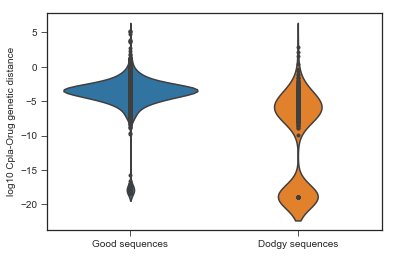

In [19]:
#plot tree distance for good sequences and potential contaminants (i.e. dodgy sequences)
sns.set_style('ticks')

lgd = [np.log2(x) for x in good_genes.values()]    
lbd = [np.log2(x) for x in contaminants.values()]    

aa = sns.violinplot(data=[lgd, lbd], scale='area', inner='point')
aa.set(ylabel = 'log10 Cpla-Orug genetic distance')
aa.set_xticklabels(['Good sequences', 'Dodgy sequences'])

plt.show()

## 3. Construct dataframe with sequence and phylogenetic features

In [20]:
#read in outputs for blastp of Cpla against Orug and two ponerines
Cpla_vs_Orug = pd.read_csv("contamination_assessment/Cpla_vs_Orug", header = None, sep='\t', names=blast_cols)
Cpla_vs_Hsal = pd.read_table("contamination_assessment/Cpla_vs_Hsal.bx", header = None, sep='\t', names=blast_cols)
Cpla_vs_Dqua = pd.read_table("contamination_assessment/Cpla_vs_Dqua.bx", header = None, sep='\t', names=blast_cols)

In [21]:
Cpla_vs_Orug.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,Cpla|SGF53585,Orug|SGF85362,66.42,1069,336,2,1,1046,1,1069,0.000000e+00,1466.0
1,Cpla|SGF47365,Orug|SGF74196,83.22,602,96,3,1,597,1,602,0.000000e+00,1026.0
2,Cpla|SGF52903,Orug|SGF82220,88.89,36,3,1,1,36,739,773,4.000000e-13,65.5
3,Cpla|SGF52724,Orug|SGF81012,91.58,558,42,4,14,569,575,1129,0.000000e+00,1001.0
4,Cpla|SGF52904,Orug|SGF71773,31.58,38,26,0,46,83,1926,1963,6.900000e-01,28.1


In [22]:
colnames = ['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']
Cpla_deseq = pd.read_csv("contamination_assessment/Camp_planatus.genes.QW.pvalues.nohed.out", 
                         sep = ' ', header=None,
                         names=colnames,
                        )

Orug_deseq = pd.read_csv("contamination_assessment/Odontomachus.genes.QW.pvalues.nohed.out", 
                         sep = ' ', header=None,
                         names=colnames,
                        )
Cpla_deseq.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Cpla|SGF53853,448.442547,4.807533,0.239711,20.055534,1.805928e-89,2.329106e-85
Cpla|SGF65151,325.278589,-6.878632,0.441929,-15.565010,1.258510e-54,8.115505e-51
Cpla|SGF47263,18334.582825,1.033610,0.078275,13.204818,8.229800e-40,3.537991e-36
Cpla|SGF53725,68.061743,-6.547125,0.541867,-12.082533,1.306324e-33,4.211914e-30
Cpla|SGF50282,60.901632,-6.238108,0.528536,-11.802606,3.784082e-32,9.760661e-29


### Create new table

In [53]:
df_genes = pd.read_table('/Users/vchandra/Desktop/alignm/biopython_test/Cpla_candidates.txt', header = None)
df_genes.columns = ['Cpla_genes']
df_genes.head()

,Cpla_genes
0,Cpla|SGF52724
1,Cpla|SGF48080
2,Cpla|SGF52907
3,Cpla|SGF52908
4,Cpla|SGF55108


In [54]:
# join the Cpla blast values to the dataframe
df_genes = pd.merge(left=df_genes, right=Cpla_vs_Orug[['qseqid', 'sseqid','pident']], 
                     left_on='Cpla_genes', right_on='qseqid', 
                     how='left'
                   )

In [55]:
# find lengths of each peptide sequence in the Orug and Cpla transcriptomes; save in dictionaries
Cpla_records = list(SeqIO.parse('contamination_assessment/Cpla_trinity.pep', 'fasta'))
Orug_records = list(SeqIO.parse('contamination_assessment/Orug_trinity.pep', 'fasta'))

s_Cpla_txome = pd.Series({str(record.name):str(record.seq) for record in Cpla_records}, name='Cpla_length')
s_Orug_txome = pd.Series({str(record.name):str(record.seq) for record in Orug_records}, name='Orug_length')

In [56]:
# append gene lengths
df_genes = df_genes.join(s_Cpla_txome.apply(len), on="qseqid")
df_genes = df_genes.join(s_Orug_txome.apply(len), on="sseqid")

In [57]:
# join the Hsal, Dqua blast values to the dataframe
df = Cpla_vs_Hsal[['qseqid','pident']].rename({'pident':'pident_vs_Hsal'},axis=1)
df_genes = pd.merge(left=df_genes, right=df, 
                     left_on='qseqid', right_on='qseqid', 
                     how='left'
                   )

df = Cpla_vs_Dqua[['qseqid','pident']].rename({'pident':'pident_vs_Dqua'},axis=1)
df_genes = pd.merge(left=df_genes, right=df, 
                     left_on='qseqid', right_on='qseqid', 
                     how='left'
                   )


In [58]:
# add mean expression of Cpla and Orug
for df,sp,col in zip([Orug_deseq, Cpla_deseq], ["Orug", "Cpla"], ['sseqid', 'qseqid']):
    df_genes = pd.merge(left=df_genes, right=df[['baseMean']], 
                         left_on=col, right_index=True, 
                         how='left'
                       ).rename({"baseMean":'{}_expressionlevel'.format(sp)}, axis=1)

In [59]:
# label contaminants and class fields
df_contaminants = pd.DataFrame({"genetic_distance":pd.Series(contaminants,),
                               "contaminated":1,
                              })

df_goodgenes = pd.DataFrame({"genetic_distance":pd.Series(good_genes),
                               "contaminated":0,
                               "class":"good",
                              })

# check there is no overlap in goodgene and contaminants lists:
print(len(df_contaminants.index.intersection(df_goodgenes.index)), "overlap in contaminant and good gene lists.")

df_concat = pd.concat([df_contaminants, df_goodgenes], axis=0)
df_concat.head(3)

0 overlap in contaminant and good gene lists.


/Users/vchandra/anaconda/envs/ilp/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


,class,contaminated,genetic_distance
Cpla|SGF48072,NaN,1,0.000002
Cpla|SGF53093,NaN,1,0.116890
Cpla|SGF51269,NaN,1,0.000002


In [60]:
df_genes = pd.merge(left=df_genes, right=df_concat, 
                     left_on='Cpla_genes', right_index=True, 
                     how='left'
                   )

In [61]:
# add RF distance
df_genes = df_genes.join(on='Cpla_genes', other=pd.Series(rfs, name="rfdistance"), how='left')

In [62]:
# add distance classification for genes ... ### add details here ###
def get_dist_class(x):
    if np.log10(x) >= -4:
        return 0
    elif np.log10(x) < -4:
        return 1
    else:
        return np.nan

df_genes['dist_classification'] = df_genes.genetic_distance.apply(get_dist_class)

In [63]:
# set Cpla expression of 0 to nan: ### WHY? ### 
df_genes.loc[df_genes.Cpla_expressionlevel == 0,'Cpla_expressionlevel'] = np.nan

In [64]:
# add the coefficient of variance for length and expression
def get_coef_vars(s):
    if s[['Cpla_length','Orug_length']].count() == 2:
        len_cfv = (s['Cpla_length'] - s['Orug_length']) / (s['Cpla_length'] + s['Orug_length'])
    else:
        len_cfv = np.nan
    if s[['Orug_expressionlevel', 'Cpla_expressionlevel']].count() == 2:
        exp_cfv = (s['Cpla_expressionlevel'] - s['Orug_expressionlevel']) / (s['Cpla_expressionlevel'] + s['Orug_expressionlevel'])
    else:
        exp_cfv = np.nan
    return pd.Series([len_cfv, exp_cfv])

df_genes[['len_coeff','exp_coeff']] = df_genes.apply(get_coef_vars, axis=1)

In [65]:
df_genes.head()

,Cpla_genes,qseqid,sseqid,pident,Cpla_length,Orug_length,pident_vs_Hsal,pident_vs_Dqua,Orug_expressionlevel,Cpla_expressionlevel,class,contaminated,genetic_distance,rfdistance,dist_classification,len_coeff,exp_coeff
0,Cpla|SGF52724,Cpla|SGF52724,Orug|SGF81012,91.58,569,1129,92.10,92.46,119.900093,965.813161,good,0.0,0.453249,0.1,0.0,-0.329800,0.779131
1,Cpla|SGF48080,Cpla|SGF48080,Orug|SGF77038,100.00,153,239,94.74,94.74,0.789648,1.318511,good,0.0,0.084874,0.5,0.0,-0.219388,0.250865
2,Cpla|SGF52907,Cpla|SGF52907,Orug|SGF82220,94.34,145,776,92.39,94.48,3594.198125,0.709656,good,0.0,0.130460,0.1,0.0,-0.685125,-0.999605
3,Cpla|SGF52908,Cpla|SGF52908,Orug|SGF71332,90.55,130,314,90.55,91.34,848.116987,1.484462,good,0.0,0.145891,0.3,0.0,-0.414414,-0.996506
4,Cpla|SGF55108,Cpla|SGF55108,Orug|SGF77881,99.34,152,239,99.34,99.34,2628.202306,2636.150630,good,0.0,0.004257,0.6,0.0,-0.222506,0.001510


In [66]:
# add the sister taxa if given:
df_genes = df_genes.join(pd.Series(s_clade, name='ctd_sis_taxon'), on='Cpla_genes', how='left')

In [67]:
def refine_verdict(s):
    if (s['contaminated'] == 1) and (s['ctd_sis_taxon'] == 'F'):
        clss = 'guilty'
    elif (s['contaminated'] == 1) and (s['ctd_sis_taxon'] == 'P' or s['ctd_sis_taxon'] == 'both'):
        clss = 'bad'
    else:
        clss = s['class']
    
    return clss
        
df_genes['class'] = df_genes.apply(refine_verdict, axis=1)

In [68]:
# adjust column names for clarity
df_genes = df_genes.rename({'pident':'pident_vs_Orug',
                             'sseqid':'Orug_genes',
                            },
                            axis=1,
                           )

In [69]:
df_genes.head()

,Cpla_genes,qseqid,Orug_genes,pident_vs_Orug,Cpla_length,Orug_length,pident_vs_Hsal,pident_vs_Dqua,Orug_expressionlevel,Cpla_expressionlevel,class,contaminated,genetic_distance,rfdistance,dist_classification,len_coeff,exp_coeff,ctd_sis_taxon
0,Cpla|SGF52724,Cpla|SGF52724,Orug|SGF81012,91.58,569,1129,92.10,92.46,119.900093,965.813161,good,0.0,0.453249,0.1,0.0,-0.329800,0.779131,NaN
1,Cpla|SGF48080,Cpla|SGF48080,Orug|SGF77038,100.00,153,239,94.74,94.74,0.789648,1.318511,good,0.0,0.084874,0.5,0.0,-0.219388,0.250865,NaN
2,Cpla|SGF52907,Cpla|SGF52907,Orug|SGF82220,94.34,145,776,92.39,94.48,3594.198125,0.709656,good,0.0,0.130460,0.1,0.0,-0.685125,-0.999605,NaN
3,Cpla|SGF52908,Cpla|SGF52908,Orug|SGF71332,90.55,130,314,90.55,91.34,848.116987,1.484462,good,0.0,0.145891,0.3,0.0,-0.414414,-0.996506,NaN
4,Cpla|SGF55108,Cpla|SGF55108,Orug|SGF77881,99.34,152,239,99.34,99.34,2628.202306,2636.150630,good,0.0,0.004257,0.6,0.0,-0.222506,0.001510,NaN


In [70]:
len(df_genes)

3510

## 4. Plots showing that these features indicate contamination
The plots below show clearly that the phylogenetic classification identifies genes in Cpla that have low expression, are very short, and have very low genetic distance to their best hit in Orug. 
Moreover, the phylogenetic classification of the parent/sister clade of these likely contaminants adds confidence to this classification. 

In [75]:
df_genes[['Cpla_expressionlevel','Orug_expressionlevel',]].stack().apply(np.log2).replace([np.inf, -np.inf], np.nan).dropna().head()

0  Cpla_expressionlevel    9.915600
   Orug_expressionlevel    6.905689
1  Cpla_expressionlevel    0.398910
   Orug_expressionlevel   -0.340719
2  Cpla_expressionlevel   -0.494809
dtype: float64

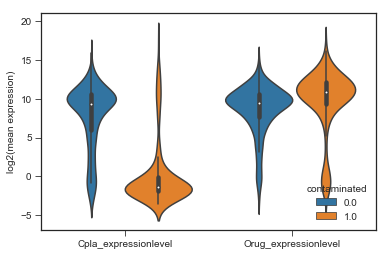

In [79]:
g = sns.violinplot(data=pd.DataFrame(df_genes[['Cpla_expressionlevel',
                                           'Orug_expressionlevel',]].stack().apply(np.log2).replace([np.inf, -np.inf], np.nan).dropna()
                                ).reset_index(1
                                ).join(df_genes[['contaminated']]
                                ),
               y=0,
               x='level_1',
               hue='contaminated',
               scale='area'
              )
plt.xlabel("")
plt.ylabel("log2(mean expression)")
plt.show()

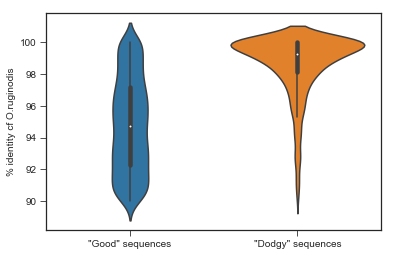

In [80]:
g = sns.violinplot(data=pd.DataFrame(df_genes[[ 'pident_vs_Orug',
                                           'contaminated',]]
                                ),
                   y='pident_vs_Orug',
                   x='contaminated',
                   scale='area' 
                  )
plt.xlabel("")
plt.ylabel("% identity cf O.ruginodis")
plt.xticks([0,1],['"Good" sequences', '"Dodgy" sequences'])
plt.show()

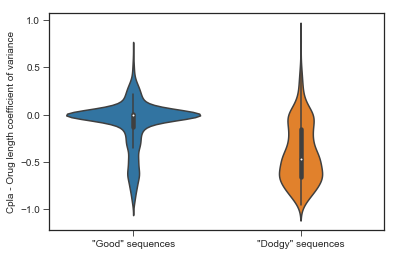

In [81]:
g = sns.violinplot(data=pd.DataFrame(df_genes[[ 'len_coeff',
                                           'contaminated',]]
                                ),
                   y='len_coeff',
                   x='contaminated',
                   scale='area' 
                  )
plt.xlabel("")
plt.ylabel("Cpla - Orug length coefficient of variance")
plt.xticks([0,1],['"Good" sequences', '"Dodgy" sequences'])
plt.show()

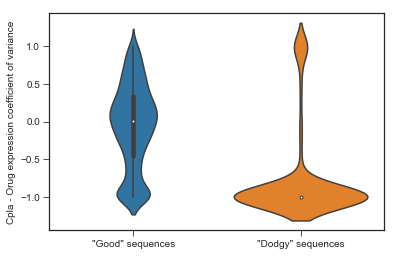

In [82]:
g = sns.violinplot(data=pd.DataFrame(df_genes[[ 'exp_coeff',
                                           'contaminated',]]
                                ),
                   y='exp_coeff',
                   x='contaminated',
                   scale='area' 
                  )
plt.xlabel("")
plt.ylabel("Cpla - Orug expression coefficient of variance")
plt.xticks([0,1],['"Good" sequences', '"Dodgy" sequences'])
plt.show()

In [83]:
#which gene is contaminated?
O_con_ldiff = []
O_con_ediff = []
C_con_ldiff = []
C_con_ediff = []

for ind, row in df_genes.iterrows():
    if row['ctd_sis_taxon'] == 'P':
        O_con_ldiff.append(row['len_coeff'])
        O_con_ediff.append(row['exp_coeff'])
    elif row['ctd_sis_taxon'] == 'F':
        C_con_ldiff.append(row['len_coeff'])
        C_con_ediff.append(row['exp_coeff'])

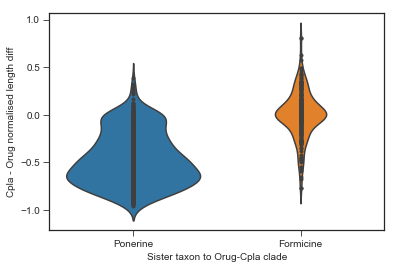

In [84]:
ax9 = sns.violinplot(data = [O_con_ldiff, C_con_ldiff], scale = 'count', inner = 'point')
ax9.set(ylabel = 'Cpla - Orug normalised length diff')
ax9.set_xticklabels(['Ponerine', 'Formicine'])
ax9.set_xlabel('Sister taxon to Orug-Cpla clade')
ax9 = sns.set_style('ticks')

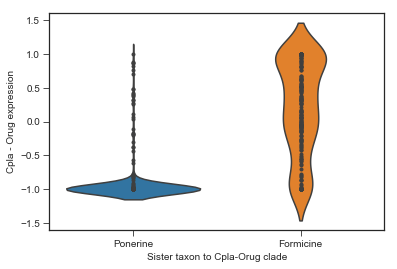

In [85]:
ax10 = sns.violinplot(data = [O_con_ediff, C_con_ediff], scale = 'count', inner = 'point')
ax10.set(ylabel = 'Cpla - Orug expression')
ax10.set_xticklabels(['Ponerine', 'Formicine'])
ax10.set_xlabel('Sister taxon to Cpla-Orug clade')
ax10 = sns.set_style('ticks')

## 5. Identify and remove contaminants from the transcriptome

In [86]:
#make list of contaminant genes that should be removed from the Orug transcriptome
#include genes if contaminated says 1 and if rfdist >= 0.6
genes_for_removal = []
count = 0
c2 = []

for ind, row in df_genes.iterrows():
    if row['class'] == 'bad':
        genes_for_removal.append(row['Cpla_genes'])
    elif row['ctd_sis_taxon'] != 'F' \
        and (row['rfdistance'] >= 0.6 or 
              pd.isnull(row['rfdistance'])
             ) \
        and (row['dist_classification'] == 1 or 
             (row['exp_coeff'] < -0.2 and 
              row['len_coeff'] < -0.2)
             ):
        genes_for_removal.append(row['Cpla_genes'])
        count += 1
    elif row['ctd_sis_taxon'] == 'P' and row['contaminated'] == 1:
        genes_for_removal.append(row['Cpla_genes'])
        c2.append(row['Cpla_genes'])
print(len(genes_for_removal), count, len(c2))

810 231 0


In [52]:
# filter Orug txome to remove contaminants:
s_clean_Cpla_txome = s_Cpla_txome[~s_Cpla_txome.index.isin(genes_for_removal)]

In [53]:
print(len(s_Cpla_txome))
print(len(s_clean_Cpla_txome))

26161
25458


In [54]:
#WRITE NEW ORUG TRANSCRIPTOME
with open('clean_Orug_txome.fasta', 'a') as f:
    for geneid in s_clean_Orug_txome.index:
        f.write('>{}\n{}\n'.format(geneid, s_clean_Orug_txome.loc[geneid]))
    f.close()